# Parallel Computing in Julia

In [12]:
using BenchmarkTools
using Random, Distributions
using Base.Threads
using Plots

In [2]:
versioninfo(verbose=true)

Julia Version 1.6.3
Commit ae8452a9e0 (2021-09-23 17:34 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
      Ubuntu 20.04.3 LTS
  uname: Linux 5.11.0-38-generic #42~20.04.1-Ubuntu SMP Tue Sep 28 20:41:07 UTC 2021 x86_64 x86_64
  CPU: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz: 
              speed         user         nice          sys         idle          irq
       #1  2900 MHz      42663 s          5 s      20764 s     299429 s          0 s
       #2  2900 MHz      44840 s         34 s      22198 s     295360 s          0 s
       #3  2900 MHz      46400 s         10 s      18050 s     299443 s          0 s
       #4  3499 MHz      44190 s         50 s      20696 s     298480 s          0 s
       
  Memory: 7.505710601806641 GB (321.60546875 MB free)
  Uptime: 36818.0 sec
  Load Avg:  0.88  0.96  0.99
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 2
  WINDOWPATH = 2
  HOME = /home/thomas
  GEM_HOME = /home/thoma

In [3]:
nthreads()

2

To create a new kernel for the jupyter notebook, run the following. Then restart jupyter notebook.

In [ ]:
using IJulia
IJulia.installkernel("Julia with 2 threads", env=Dict(
    "JULIA_NUM_THREADS" => "2",
))

In [ ]:
nthreads()

In [ ]:
s = zeros(1000)
@btime for i in 1:1000
    s[i] = i
end

In [ ]:
s = zeros(1000)
@btime @threads for i in 1:1000
    s[i] = i
end

10000

In [2]:
function sim_GaussMix(K, nobs)
    # Priors
    π_prior = Dirichlet(ones(K))
    μ_prior = Normal(0, 5)
    σ²_prior = InverseGamma(3, 5)
    # Simulate parameters
    cl_probs = rand(π_prior, 1)[:, 1]
    mu_mat = rand(μ_prior, K)
    sgm_mat = sqrt.(rand(σ²_prior, K))
    # Construct mixture
    mymixture = MixtureModel(Normal, [(mu_mat[k], sgm_mat[k]) for k in 1:K], cl_probs)
    # Simulate from mixture and return data and mixture
    y = rand(mymixture, nobs)
    return y, mymixture 
end

sim_GaussMix (generic function with 1 method)

In [35]:
K = 4
nobs = 10000
y, mymixture = sim_GaussMix(K, nobs);

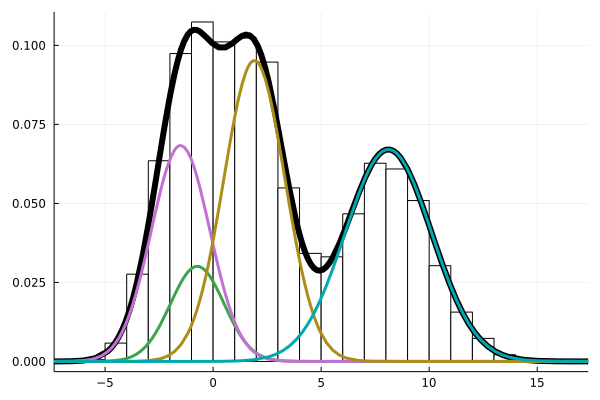

In [36]:
histogram(y, normalize = :pdf, fillcolor = "white", label = "")
plot!(x -> pdf(mymixture, x), xlim = xlims(), linewidth = 6, 
    linecolor = "black", label = "")
for k in 1:K
    plot!(x->pdf(components(mymixture)[k], x) * probs(mymixture)[k], 
        xlim=xlims(), linewidth = 3, label = "")
end
plot!()

In [37]:
savefig("gaussmix.pdf")

In [73]:
mutable struct myGaussMix
    """
    A very simple implementation of a Gaussian mixture model.
    """
    μ # component means
    σ # component standard devs
    π # component probabilities
    π_post # posterior component probabilities
    y # data
    K # number of components
    
    function myGaussMix(y, K)
        # Initialize component parameters randomly
        μ = rand(Normal(0, std(y)), K)
        σ = std(y) * ones(K) ./ K
        π = rand(Dirichlet(ones(K)))
        π_post = zeros((nobs, K))
        # Construct object
        new(μ, σ, π, π_post, y, K)
    end
end

In [74]:
function fit!(m::myGaussMix; max_iter = 1000, tol = 1e-3)
    """
    A very simple implementation of an EM algorithm for fitting a
        Gaussian mixture model.
    """
    # Get values from m
    μ = m.μ; σ = m.σ
    π = m.π; π_post = m.π_post
    K = m.K
    # Data parameters
    nobs = length(m.y)
    # Run EM algorithm
    likeli = zeros((nobs, K))
    log_l = zeros(max_iter)
    log_l_old = -9e6
    for j in 1:max_iter
        # E-step      
        for k in 1:K
            likeli[:, k] = pdf(Normal(μ[k], σ[k]), m.y) .* π[k]
        end
        π_post = likeli ./ repeat(mapslices(sum, likeli, dims = 2)', K)'
        
        # M-step
        for k in 1:K
            π[k] = mean(π_post[:, k])
            μ[k] = sum(m.y .* π_post[:, k]) ./ sum(π_post[:, k])
            σ[k] = sum((m.y .- μ[k]).^2 .* π_post[:, k]) ./ sum(π_post[:, k])
            σ[k] = sqrt(σ[k])
        end
        
        # Compute current value of the likelihood
        mixture_j = MixtureModel(Normal, [(μ[k], σ[k]) for k in 1:K], π)
        log_l[j] = sum(logpdf(mixture_j, m.y))
        
        # Check for convergence
        if (log_l[j] - log_l_old) < tol
            break
        end
    end
    # Export values to m
    m.μ = μ; m.σ = σ
    m.π = π; m.π_post = π_post
    return nothing
end

fit! (generic function with 1 method)

In [75]:
mygm = myGaussMix(y, K);
@btime fit!(mygm, max_iter = 1000, tol = 1e-6)

  19.418 s (658602494 allocations: 20.26 GiB)


In [76]:
function par_fit!(m::myGaussMix; max_iter = 1000, tol = 1e-3)
    """
    A very simple implementation of an EM algorithm for fitting a
        Gaussian mixture model.
    """
    # Get values from m
    μ = m.μ; σ = m.σ
    π = m.π; π_post = m.π_post
    K = m.K
    # Data parameters
    nobs = length(m.y)
    # Run EM algorithm
    likeli = zeros((nobs, K))
    log_l = zeros(max_iter)
    log_l_old = -9e6
    for j in 1:max_iter
        # E-step      
        @threads for k in 1:K
            likeli[:, k] = pdf(Normal(μ[k], σ[k]), m.y) .* π[k]
        end
        π_post = likeli ./ repeat(mapslices(sum, likeli, dims = 2)', K)'
        
        # M-step
        @threads for k in 1:K
            π[k] = mean(π_post[:, k])
            μ[k] = sum(m.y .* π_post[:, k]) ./ sum(π_post[:, k])
            σ[k] = sum((m.y .- μ[k]).^2 .* π_post[:, k]) ./ sum(π_post[:, k])
            σ[k] = sqrt(σ[k])
        end
        
        # Compute current value of the likelihood
        mixture_j = MixtureModel(Normal, [(μ[k], σ[k]) for k in 1:K], π)
        log_l[j] = sum(logpdf(mixture_j, m.y))
        
        # Check for convergence
        if (log_l[j] - log_l_old) < tol
            break
        end
    end
    # Export values to m
    m.μ = μ; m.σ = σ
    m.π = π; m.π_post = π_post
    return nothing
end

par_fit! (generic function with 1 method)

In [77]:
mygm = myGaussMix(y, K);
@btime par_fit!(mygm, max_iter = 1000, tol = 1e-6)

  19.522 s (658566516 allocations: 20.26 GiB)


In [ ]:
function myEM(m::myGaussMix, max_iter = 1000, tol = 1e-3)
    
    # Get parameters from m
    nobs = 
    K = m.K
    post_probs = zeros((nobs, K))
    prior_probs = rand(Dirichlet(ones(K)))
    mu_mat = rand(Normal(0, 1), K)
    sgm_mat = 3 * ones(K)

    likeli_i = zeros(K)
    log_likeli = zeros(max_iter)
    log_likeli_old = -999999
    for j in 1:max_iter
            # E-step
            for i in 1:nobs
                for k in 1:K
                    likeli_i[k] = pdf(Normal(mu_mat[k], sgm_mat[k]), y[i]) * 
                        prior_probs[k]
                end
                post_probs[i, :] = likeli_i ./ sum(likeli_i)
            end

            # M-step
            for k in 1:K
                prior_probs[k] = mean(post_probs[:, k])
                mu_mat[k] = sum(y .* post_probs[:, k]) ./ sum(post_probs[:, k])
                sgm_mat[k] = sum((y .- mu_mat[k]).^2 .* post_probs[:, k]) ./ 
                    sum(post_probs[:, k])
                sgm_mat[k] = sqrt(sgm_mat[k])
            end

            # Compute current value of the likelihood
            mixture_j = MixtureModel(Normal, 
                    [(mu_mat[k], sgm_mat[k]) for k in 1:K], 
                    prior_probs)
            log_likeli[j] = sum(logpdf(mixture_j, y))

            # Check for convergence
            if (log_likeli[j] - log_likeli_old) < tol
                break
            end
        end
end

In [ ]:
struct myGaussMixEM
    μ
    σ
    π
    π_post
    y 
    log_l
    
    function myGaussMixEM(y, K; max_iter = 1000, tol = 1e-3)
        # Initialize posterior probabilities
        post_probs = zeros((nobs, K))
        prior_probs = rand(Dirichlet(ones(K)))
        mu_mat = rand(Normal(0, 1), K)
        sgm_mat = 3 * ones(K)

        likeli_i = zeros(K)
        log_likeli = zeros(max_iter)
        log_likeli_old = -999999
        for j in 1:max_iter
            # E-step
            for i in 1:nobs
                for k in 1:K
                    likeli_i[k] = pdf(Normal(mu_mat[k], sgm_mat[k]), y[i]) * 
                        prior_probs[k]
                end
                post_probs[i, :] = likeli_i ./ sum(likeli_i)
            end

            # M-step
            for k in 1:K
                prior_probs[k] = mean(post_probs[:, k])
                mu_mat[k] = sum(y .* post_probs[:, k]) ./ sum(post_probs[:, k])
                sgm_mat[k] = sum((y .- mu_mat[k]).^2 .* post_probs[:, k]) ./ 
                    sum(post_probs[:, k])
                sgm_mat[k] = sqrt(sgm_mat[k])
            end

            # Compute current value of the likelihood
            mixture_j = MixtureModel(Normal, 
                    [(mu_mat[k], sgm_mat[k]) for k in 1:K], 
                    prior_probs)
            log_likeli[j] = sum(logpdf(mixture_j, y))

            # Check for convergence
            if (log_likeli[j] - log_likeli_old) < tol
                break
            end
        end
        new(mu_mat, sgm_mat, prior_probs, post_probs, y, log_likeli)
    end
end

In [ ]:
fit_gaussmix = myGaussMixEM(y, K; max_iter = 1000, tol = 1e-3);

In [ ]:
@btime fit_gaussmix = myGaussMixEM(y, K; max_iter = 1000, tol = 1e-3);

In [ ]:
sort(fit_gaussmix.μ) .- sort(mu_mat)

In [ ]:
sort(fit_gaussmix.μ) .- sort(mu_mat)

In [ ]:
mu_mat

In [ ]:
# Load additional dependencies
using DataFrames, CSV
using Distributions

# Simulation hyperparameters
nobs = 100
nX = 3

# Simulate from a linear DGP ===================================================

# This section simulates from the linear regression model. 
X = randn((nobs, nX))
β = randn(nX)
ϵ = randn(nobs)
y = X * β + ϵ

# Estimation ===================================================================

# Calculates the ols coefficient
β_ols = inv(X' * X) * (X' * y)

In [2]:
# Simulation hyperparameters
nobs = 10000
nX = 3
nsim = 1000

1000

In [22]:
function simple_mc(nobs, nX, nsim)  
    β_mat = zeros((nsim, nX))
    for s in 1:nsim
        # Simulate data
        X = randn((nobs, nX))
        y = X * ones(nX) + randn(nobs)
        # Estimate the ols coefficient
        β_mat[s, :] = inv(X' * X) * (X' * y)
    end
    return β_mat
end


simple_mc (generic function with 1 method)

In [24]:
@btime simple_mc(nobs, nX, nsim); 

  494.110 ms (16002 allocations: 460.47 MiB)


In [20]:
function par_simple_mc(nobs, nX, nsim)  
    β_mat = zeros((nsim, nX))
    rnglist = [MersenneTwister() for i in 1:nthreads()]
    @threads for s in 1:nsim
        # Simulate data
        X = randn(rnglist[threadid()], (nobs, nX))
        y = X * ones(nX) + randn(rnglist[threadid()], nobs)
        # Estimate the ols coefficient
        β_mat[s, :] = inv(X' * X) * (X' * y)
    end
    return β_mat
end

par_simple_mc (generic function with 1 method)

In [26]:
@btime par_simple_mc(nobs, nX, nsim);  

  259.005 ms (16038 allocations: 460.51 MiB)


In [13]:
const rnglist = [MersenneTwister() for i in 1:nthreads()]

2-element Vector{MersenneTwister}:
 MersenneTwister(0xfc2cda7142be3a49c1a58afa09f67700)
 MersenneTwister(0x126b323b841b7bbec761f36108d8d66c)

In [14]:
randn(rnglist[threadid()], (2, 3))

2×3 Matrix{Float64}:
 -2.14897   2.04058   0.294615
  0.465842  0.509789  0.187385